In [51]:
import pandas as pd
import numpy as np
import os
import gc
import time
import polars as pl
from tqdm import tqdm
import itertools
from itertools import combinations
import warnings
from numba import njit, prange
from sklearn.linear_model import Lasso
from functools import wraps
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
def time_it(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()  # 记录开始时间
        result = func(*args, **kwargs)  # 调用被装饰的函数
        end_time = time.time()  # 记录结束时间
        execution_time = end_time - start_time  # 计算执行时间
        print(f"Function '{func.__name__}' executed in {execution_time:.4f} seconds")
        return result  # 返回函数结果
    return wrapper

In [4]:
def downcast_dtypes(df):
    for col in df.columns:
        if df[col].dtype == pl.Float64:
            df = df.with_columns(pl.col(col).cast(pl.Float32))
        elif df[col].dtype == pl.Int64:
            df = df.with_columns(pl.col(col).cast(pl.Int32))
    return df

# 1.数据读取

In [5]:
ORIGINAL_TRAIN = pd.read_csv('./optiver-trading-at-the-close/train.csv',engine = 'pyarrow')
ORIGINAL_TRAIN = pl.from_pandas(ORIGINAL_TRAIN)
cross_section_features = pl.read_parquet('cross_section_features.parquet')
ipynb_features = pl.read_parquet('ipynb_features.parquet')
market_features = pl.read_parquet('market_features.parquet')
rank9_features = pl.read_parquet('rank9_features.parquet')
timeseries_features = pl.read_parquet('timeseries_features.parquet')

In [6]:
market_features_with_row = market_features.with_columns(
    (pl.col("date_id").cast(pl.Utf8) + "_" +
     pl.col("seconds_in_bucket").cast(pl.Utf8) + "_" +
     pl.col("stock_id").cast(pl.Utf8)).alias("row_id")
)
del market_features
gc.collect()

0

In [7]:
same_cols = ['date_id', 'seconds_in_bucket', 'stock_id']
market_features_with_row = market_features_with_row[[i for i in market_features_with_row.columns if i not in same_cols]]
# rank9_features = rank9_features[[i for i in rank9_features.columns if i not in same_cols]]
cross_section_features = cross_section_features[[i for i in cross_section_features.columns if i not in same_cols]]
ipynb_features = ipynb_features[[i for i in ipynb_features.columns if i not in same_cols]]
timeseries_features = timeseries_features[[i for i in timeseries_features.columns if i not in same_cols]]
rank9_features = rank9_features[[i for i in rank9_features.columns if i not in same_cols]]

In [8]:
market_features_with_row = downcast_dtypes(market_features_with_row)
cross_section_features = downcast_dtypes(cross_section_features)
ipynb_features = downcast_dtypes(ipynb_features)
timeseries_features = downcast_dtypes(timeseries_features)
rank9_features = downcast_dtypes(rank9_features)

In [9]:
data_with_all_features_1 = (ORIGINAL_TRAIN.join(market_features_with_row, on="row_id", how="left")) 
data_with_all_features_2 = (data_with_all_features_1.join(cross_section_features, on="row_id", how="left"))
same_cols_2 = list(set(data_with_all_features_2.columns) & set(ipynb_features.columns) - set(['row_id']))
ipynb_features = ipynb_features[[i for i in ipynb_features.columns if i not in same_cols_2]]
data_with_all_features_3 = (data_with_all_features_2.join(ipynb_features, on="row_id", how="left"))
same_cols_3 = list(set(data_with_all_features_3.columns) & set(timeseries_features.columns) - set(['row_id']))
timeseries_features = timeseries_features[[i for i in timeseries_features.columns if i not in same_cols_3]]
data_with_all_features_4 = (data_with_all_features_3.join(timeseries_features, on="row_id", how="left"))
same_cols_4 = list(set(data_with_all_features_4.columns) & set(rank9_features.columns) - set(['row_id']))
rank9_features = rank9_features[[i for i in rank9_features.columns if i not in same_cols_4]]
data_with_all_features_5 = (data_with_all_features_4.join(rank9_features, on="row_id", how="left"))
data_with_all_features_5 = data_with_all_features_5[[i for i in data_with_all_features_5.columns if 'right' not in i]]
del market_features_with_row
del ORIGINAL_TRAIN
del cross_section_features
del ipynb_features
del timeseries_features
del rank9_features
del data_with_all_features_1
del data_with_all_features_2
del data_with_all_features_3
del data_with_all_features_4
gc.collect()

0

In [10]:
data_with_all_features_5

stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,index_wap_std,index_ret1,index_ret1_std,index_ret1_w,index_ret6,index_ret6_std,index_ret6_w,market_volume,market_spread,market_max_spread,mfd,wap_x,reference_price_minus_far_price,reference_price_times_far_price,reference_price_far_price_imb,reference_price_minus_near_price,reference_price_times_near_price,reference_price_near_price_imb,reference_price_minus_ask_price,reference_price_times_ask_price,…,far_price_group_first_ratio,near_price_group_first_ratio,bid_price_group_first_ratio,bid_size_group_first_ratio,ask_price_group_first_ratio,ask_size_group_first_ratio,wap_group_first_ratio,imbalance_size_group_expanding_mean_108,reference_price_group_expanding_mean_108,matched_size_group_expanding_mean_108,far_price_group_expanding_mean_108,near_price_group_expanding_mean_108,bid_price_group_expanding_mean_108,bid_size_group_expanding_mean_108,ask_price_group_expanding_mean_108,ask_size_group_expanding_mean_108,wap_group_expanding_mean_108,imbalance_size_seconds_in_bucket_group_mean_ratio,reference_price_seconds_in_bucket_group_mean_ratio,matched_size_seconds_in_bucket_group_mean_ratio,far_price_seconds_in_bucket_group_mean_ratio,near_price_seconds_in_bucket_group_mean_ratio,bid_price_seconds_in_bucket_group_mean_ratio,bid_size_seconds_in_bucket_group_mean_ratio,ask_price_seconds_in_bucket_group_mean_ratio,ask_size_seconds_in_bucket_group_mean_ratio,wap_seconds_in_bucket_group_mean_ratio,imbalance_size_seconds_in_bucket_group_rank,reference_price_seconds_in_bucket_group_rank,matched_size_seconds_in_bucket_group_rank,far_price_seconds_in_bucket_group_rank,near_price_seconds_in_bucket_group_rank,bid_price_seconds_in_bucket_group_rank,bid_size_seconds_in_bucket_group_rank,ask_price_seconds_in_bucket_group_rank,ask_size_seconds_in_bucket_group_rank,wap_seconds_in_bucket_group_rank
i64,i64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,0,0,3.1806e6,1,0.999812,1.3380e7,null,null,0.999812,60651.5,1.000026,8493.03,1.0,-3.029704,0,"""0_0_0""",0.0,null,null,0.0,null,null,0.0,67781.164062,0.000762,0.005837,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000214,0.999838,…,null,null,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,null,null,1.0,1.0,1.0,1.0,1.0,2.397408,1.000136,1.050224,null,null,0.999812,0.521599,1.000361,4.255888,1.0,0.340314,0.659686,0.204188,null,null,0.497382,0.104712,0.931937,0.685864,0.005236
1,0,0,166603.91,-1,0.999896,1.6422e6,null,null,0.999896,3233.04,1.00066,20605.09,1.0,-5.519986,0,"""0_0_1""",0.0,null,null,0.0,null,null,0.0,67781.164062,0.000762,0.005837,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000764,1.000556,…,null,null,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,null,null,1.0,1.0,1.0,1.0,1.0,45.768456,1.000052,8.556917,null,null,0.999728,9.785149,0.999727,1.754197,1.0,0.806283,0.554974,0.874346,null,null,0.272251,0.827225,0.183246,0.439791,0.010471
2,0,0,302879.87,-1,0.999561,1.8194e6,null,null,0.999403,37956.0,1.000298,18995.0,1.0,-8.38995,0,"""0_0_2""",0.0,null,null,0.0,null,null,0.0,67781.164062,0.000762,0.005837,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000737,0.999859,…,null,null,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,null,null,1.0,1.0,1.0,1.0,1.0,25.175671,1.000387,7.723721,null,null,1.000221,0.833486,1.000089,1.902889,1.0,0.753927,0.811518,0.82199,null,null,0.795812,0.225131,0.434555,0.455497,0.015707
3,0,0,1.1918e7,-1,1.000171,1.8390e7,null,null,0.999999,2324.9,1.000214,479032.4,1.0,-4.0102,0,"""0_0_3""",0.0,null,null,0.0,null,null,0.0,67781.164062,0.000762,0.005837,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000043,1.000385,…,null,null,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,null,null,1.0,1.0,1.0,1.0,1.0,0.639823,0.999777,0.764137,null,null,0.999625,13.60737,1.

# 2.训练集划分

In [13]:
data_with_all_features_ten_days =  data_with_all_features_5.filter((pl.col('date_id')>=70) & (pl.col('date_id')<=80))
data_with_all_features_ten_days

stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,index_wap_std,index_ret1,index_ret1_std,index_ret1_w,index_ret6,index_ret6_std,index_ret6_w,market_volume,market_spread,market_max_spread,mfd,wap_x,reference_price_minus_far_price,reference_price_times_far_price,reference_price_far_price_imb,reference_price_minus_near_price,reference_price_times_near_price,reference_price_near_price_imb,reference_price_minus_ask_price,reference_price_times_ask_price,…,far_price_group_first_ratio,near_price_group_first_ratio,bid_price_group_first_ratio,bid_size_group_first_ratio,ask_price_group_first_ratio,ask_size_group_first_ratio,wap_group_first_ratio,imbalance_size_group_expanding_mean_108,reference_price_group_expanding_mean_108,matched_size_group_expanding_mean_108,far_price_group_expanding_mean_108,near_price_group_expanding_mean_108,bid_price_group_expanding_mean_108,bid_size_group_expanding_mean_108,ask_price_group_expanding_mean_108,ask_size_group_expanding_mean_108,wap_group_expanding_mean_108,imbalance_size_seconds_in_bucket_group_mean_ratio,reference_price_seconds_in_bucket_group_mean_ratio,matched_size_seconds_in_bucket_group_mean_ratio,far_price_seconds_in_bucket_group_mean_ratio,near_price_seconds_in_bucket_group_mean_ratio,bid_price_seconds_in_bucket_group_mean_ratio,bid_size_seconds_in_bucket_group_mean_ratio,ask_price_seconds_in_bucket_group_mean_ratio,ask_size_seconds_in_bucket_group_mean_ratio,wap_seconds_in_bucket_group_mean_ratio,imbalance_size_seconds_in_bucket_group_rank,reference_price_seconds_in_bucket_group_rank,matched_size_seconds_in_bucket_group_rank,far_price_seconds_in_bucket_group_rank,near_price_seconds_in_bucket_group_rank,bid_price_seconds_in_bucket_group_rank,bid_size_seconds_in_bucket_group_rank,ask_price_seconds_in_bucket_group_rank,ask_size_seconds_in_bucket_group_rank,wap_seconds_in_bucket_group_rank
i64,i64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,70,0,102375.26,1,0.999846,1.2708e7,null,null,0.999628,77945.0,1.000064,13485.78,1.0,-4.220009,3850,"""70_0_0""",0.0,null,null,0.0,null,null,0.0,66871.421875,0.000946,0.007534,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000218,0.99991,…,null,null,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,null,null,1.0,1.0,1.0,1.0,1.0,81.533516,1.000208,2.341745,null,null,0.999918,0.378879,1.000428,2.768819,1.0,0.887755,0.647959,0.326531,null,null,0.622449,0.076531,0.852041,0.576531,0.005102
1,70,0,0.0,0,1.000868,975990.33,null,null,0.999971,167.26,1.000868,5022.3,1.0,1.399517,3850,"""70_0_1""",0.0,null,null,0.0,null,null,0.0,66871.421875,0.000946,0.007534,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.001737,…,null,null,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,null,null,1.0,1.0,1.0,1.0,1.0,inf,0.999187,30.490795,null,null,0.999575,176.56189,0.999625,7.434778,1.0,0.913265,0.137755,0.933673,null,null,0.112245,1.0,0.19898,0.831633,0.010204
2,70,0,154079.43,1,1.000001,1.1656e6,null,null,0.999603,51163.62,1.000001,175.89,1.0,-2.040267,3850,"""70_0_2""",0.0,null,null,0.0,null,null,0.0,66871.421875,0.000946,0.007534,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000002,…,null,null,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,null,null,1.0,1.0,1.0,1.0,1.0,54.173454,1.000053,25.53035,null,null,0.999943,0.577202,1.000491,212.289978,1.0,0.846939,0.494898,0.908163,null,null,0.642857,0.158163,0.994898,0.979592,0.015306
3,70,0,5.3680e6,-1,0.999996,1.5564e8,null,null,0.999908,22787.0,1.00004,9799.7,1.0,-2.290011,3850,"""70_0_3""",0.0,null,null,0.0,null,null,0.0,66871.421875,0.000946,0.007534,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000044,1.000036,…,null,null,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,null,null,1.0,1.0,1.0,1.0,1.0,1.554966,1.000058,0.191203,null,null,0.999638,1.295991,1.000452

In [36]:
y = data_with_all_features_ten_days['target']
X = data_with_all_features_ten_days.select(pl.exclude(['target', 'stock_id', 'date_id', 'seconds_in_bucket', 'row_id', 'time_id']))
X = X.select(pl.exclude(pl.String))
# 2. 将数据转换为 NumPy 数组以便于后续处理
feature_names = X.columns
X_np = X.to_numpy()
y_np = y.to_numpy()

# 检查无穷大值
has_inf = np.isinf(X_np).any()
print(f"数据中是否存在无穷大值: {has_inf}")

# 检查 NaN 值
has_nan = np.isnan(X_np).any()
print(f"数据中是否存在 NaN 值: {has_nan}")
# 将无穷大值替换为 NaN
X_np[np.isinf(X_np)] = np.nan

# 使用列的均值填充 NaN 值
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_np = imputer.fit_transform(X_np)

# 3. 切分训练和验证数据集
X_train, X_val, y_train, y_val = train_test_split(X_np, y_np, test_size=0.2, random_state=42)

# 4. 数据的量纲处理（标准化）
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # 只在训练集上拟合
X_val = scaler.transform(X_val)         # 在验证集上使用同样的缩放参数
# 转换回 DataFrame 以便使用列名
X_train = pd.DataFrame(X_train, columns=feature_names)
X_val = pd.DataFrame(X_val, columns=feature_names)

# 输出结果
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

数据中是否存在无穷大值: True
数据中是否存在 NaN 值: True
X_train shape: (94864, 429)
X_val shape: (23716, 429)
y_train shape: (94864,)
y_val shape: (23716,)


# 3.树的特征重要性选择

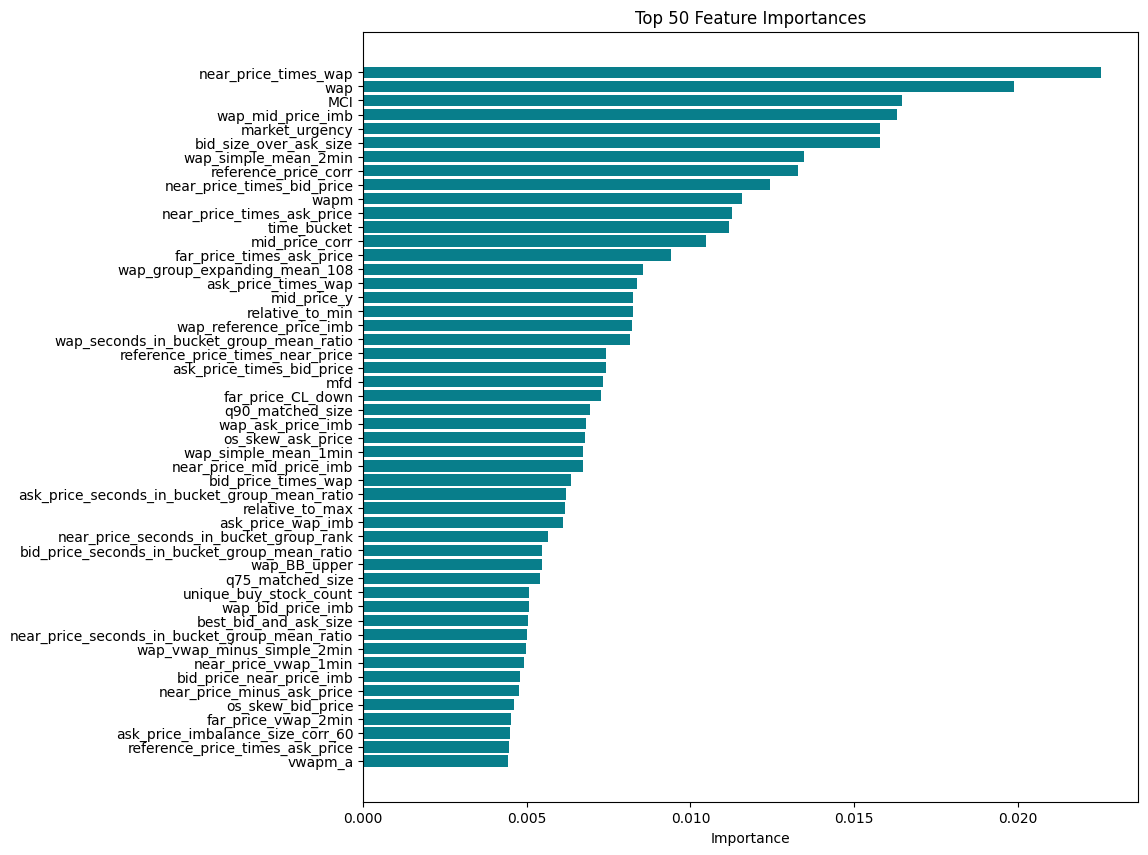

Feature: near_price_times_wap, Importance: 0.0226
Feature: wap, Importance: 0.0199
Feature: MCI, Importance: 0.0165
Feature: wap_mid_price_imb, Importance: 0.0163
Feature: market_urgency, Importance: 0.0158
Feature: bid_size_over_ask_size, Importance: 0.0158
Feature: wap_simple_mean_2min, Importance: 0.0135
Feature: reference_price_corr, Importance: 0.0133
Feature: near_price_times_bid_price, Importance: 0.0124
Feature: wapm, Importance: 0.0116
Feature: near_price_times_ask_price, Importance: 0.0113
Feature: time_bucket, Importance: 0.0112
Feature: mid_price_corr, Importance: 0.0105
Feature: far_price_times_ask_price, Importance: 0.0094
Feature: wap_group_expanding_mean_108, Importance: 0.0085
Feature: ask_price_times_wap, Importance: 0.0084
Feature: mid_price_y, Importance: 0.0083
Feature: relative_to_min, Importance: 0.0082
Feature: wap_reference_price_imb, Importance: 0.0082
Feature: wap_seconds_in_bucket_group_mean_ratio, Importance: 0.0081
Feature: reference_price_times_near_price

In [37]:
# 树的特征重要性可视化
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# 假设您已经有训练好的模型和特征名称
model = XGBRegressor()
model.fit(X_train, y_train)

# 获取特征名称
feature_names = X.columns

# 提取特征重要性并排序
importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

# 可视化前 N 个重要特征
N = 50  # 选择前 N 个特征进行可视化
plt.figure(figsize=(10, 10))
plt.barh(importances['Feature'][:N][::-1], importances['Importance'][:N][::-1], color='#087E8B')
plt.xlabel('Importance')
plt.title(f'Top {N} Feature Importances')
plt.show()

# 输出所有特征的重要性，每行一个
for feature, importance in zip(importances['Feature'], importances['Importance']):
    print(f'Feature: {feature}, Importance: {importance:.4f}')

In [38]:
threshold = 0.0001
selected_features = importances[importances['Importance'] > threshold]['Feature']

# 5. 更新训练和验证集，仅保留筛选后的特征
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]

# 输出结果
print(f"原始特征数量: {X_train.shape[1]}")
print(f"筛选后特征数量: {X_train_selected.shape[1]}")

原始特征数量: 429
筛选后特征数量: 348


# 4.PCA 主成分分析

主成分分析（Principal Component Analysis，PCA）是一种统计方法，旨在通过线性变换将高维数据投影到低维空间，同时尽可能保留原始数据的主要信息。其核心思想是：

数据中心化：将原始数据的每个特征减去其均值，使数据的中心移动到原点。

计算协方差矩阵：在中心化的数据基础上，计算各特征之间的协方差矩阵，以衡量特征间的线性相关性。

特征值分解：对协方差矩阵进行特征值分解，得到特征值和对应的特征向量。特征值表示数据在对应特征向量方向上的方差大小。

选择主成分：根据特征值的大小，选择前k个特征值最大的特征向量作为主成分方向。通常，选择的主成分应能解释数据中大部分的方差。

数据投影：将原始数据投影到选定的主成分方向上，得到降维后的数据表示。

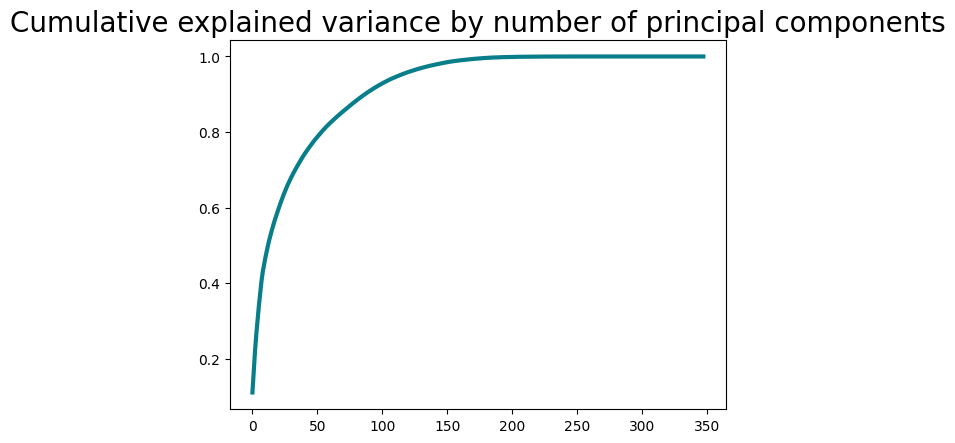

In [39]:
from sklearn.decomposition import PCA
# 拟合PCA模型，提取主成分
pca = PCA().fit(X_train_selected)
# 计算累计解释方差
plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.title('Cumulative explained variance by number of principal components', size=20)
plt.show()

In [41]:

loadings = pd.DataFrame(
    # pca.components_每一行表示一个主成分，每列表示一个特征在该主成分上的系数。
    # 使得每个特征的系数被解释方差缩放，表示特征在各主成分上的贡献。
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns=[f'PC{i}' for i in range(1, len(X_train_selected.columns) + 1)],
    index=X_train_selected.columns
)
# 单元格值表示该特征在对应主成分上的载荷，即该特征在这个主成分上的贡献大小和方向。
loadings.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC339,PC340,PC341,PC342,PC343,PC344,PC345,PC346,PC347,PC348
near_price_times_wap,-0.070663,0.825711,-0.083319,-0.351872,0.027431,-0.121572,-0.048149,0.208463,0.002140,0.016900,...,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0
wap,0.932737,0.047868,0.204027,-0.108500,-0.090199,0.079316,0.103996,-0.010464,0.037676,0.057972,...,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0
MCI,-0.022873,-0.025803,0.013419,0.028142,0.004244,-0.036164,-0.019160,0.112805,-0.366745,0.066187,...,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0
wap_mid_price_imb,0.057855,0.058521,-0.033663,-0.057172,0.016329,0.084471,0.057274,-0.255774,0.811909,-0.208414,...,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0
market_urgency,0.057793,0.058652,-0.033673,-0.057263,0.016464,0.084602,0.057214,-0.256132,0.811778,-0.208359,...,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0


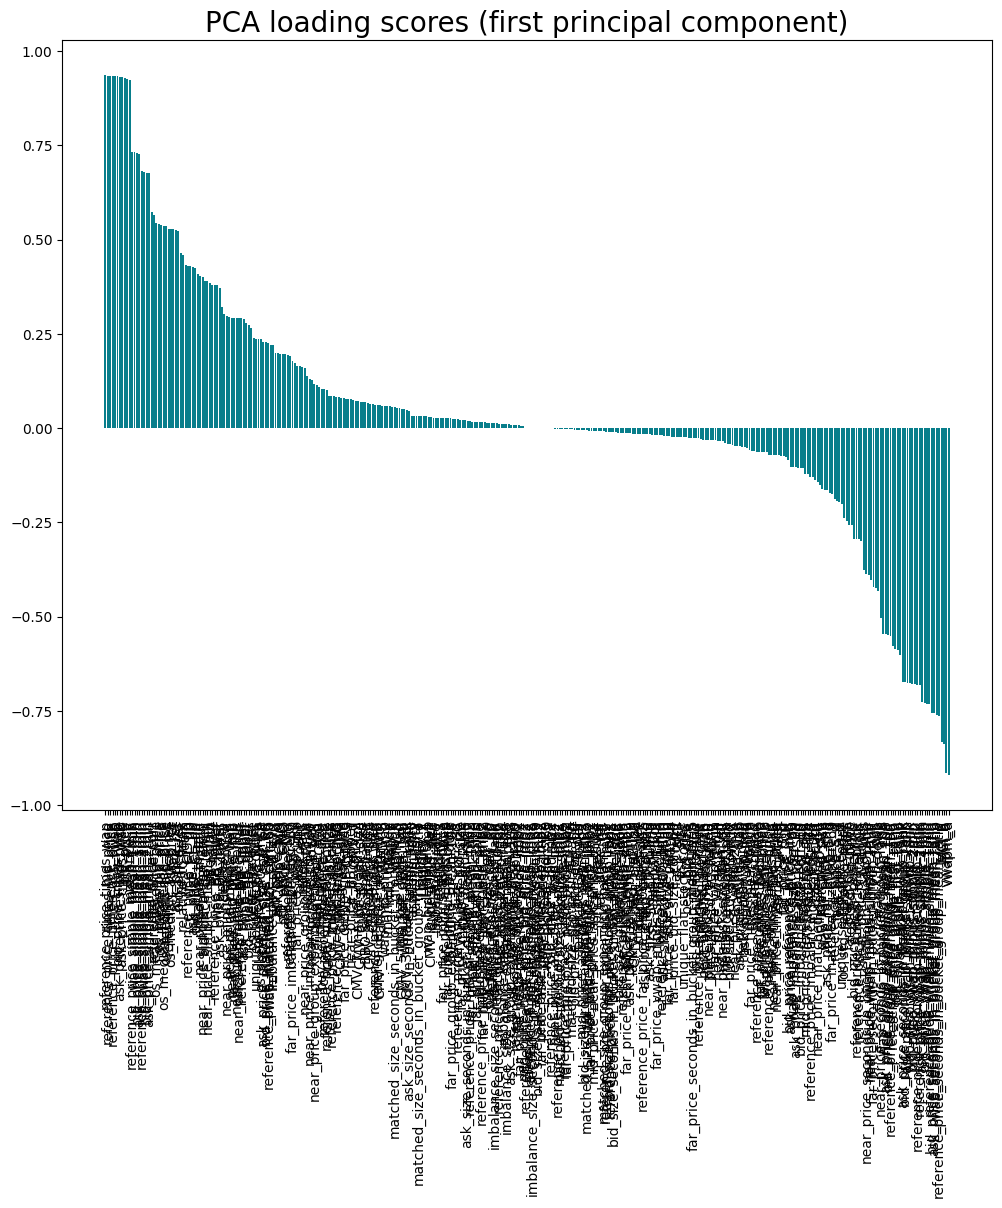

In [45]:
pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
pc1_loadings = pc1_loadings.reset_index()
pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']

plt.figure(figsize=(12, 10))
plt.bar(x=pc1_loadings['Attribute'], height=pc1_loadings['CorrelationWithPC1'], color='#087E8B')
plt.title('PCA loading scores (first principal component)', size=20)
plt.xticks(rotation='vertical')
plt.show()

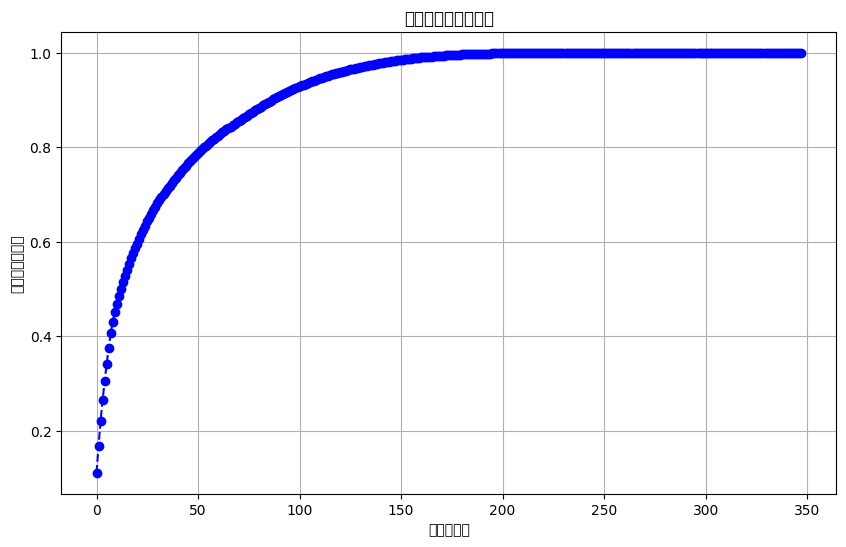

为了达到 95.0% 的累积方差贡献率，需要选择前 115 个主成分。


In [48]:
pca = PCA()

# 拟合模型
pca.fit(X_train_selected)

# 计算累积方差贡献率
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# 绘制累积方差贡献率曲线
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_ratio, marker='o', linestyle='--', color='b')
plt.xlabel('主成分数量')
plt.ylabel('累积方差贡献率')
plt.title('累积方差贡献率曲线')
plt.grid(True)
plt.show()

# 设定阈值，例如 95%,阈值越低
threshold = 0.95

# 找到累积方差贡献率首次达到阈值的位置
num_components = np.argmax(cumulative_variance_ratio >= threshold) + 1

print(f"为了达到 {threshold*100}% 的累积方差贡献率，需要选择前 {num_components} 个主成分。")

# 5.lasso分析
Lasso回归（最小绝对收缩和选择算子）是一种线性回归方法，通过引入L1正则化项，实现特征选择和模型稀疏化。

L1正则化项会对回归系数施加约束，迫使某些系数缩小甚至变为零，从而实现特征选择。这意味着模型仅保留对预测结果影响较大的特征，提升模型的可解释性和泛化能力。

当$\lambda$较大时，更多的系数被压缩为零，模型变得更为稀疏，特征选择效果更明显。
当$\lambda$较小时，正则化效果减弱，模型趋向于包含更多特征。


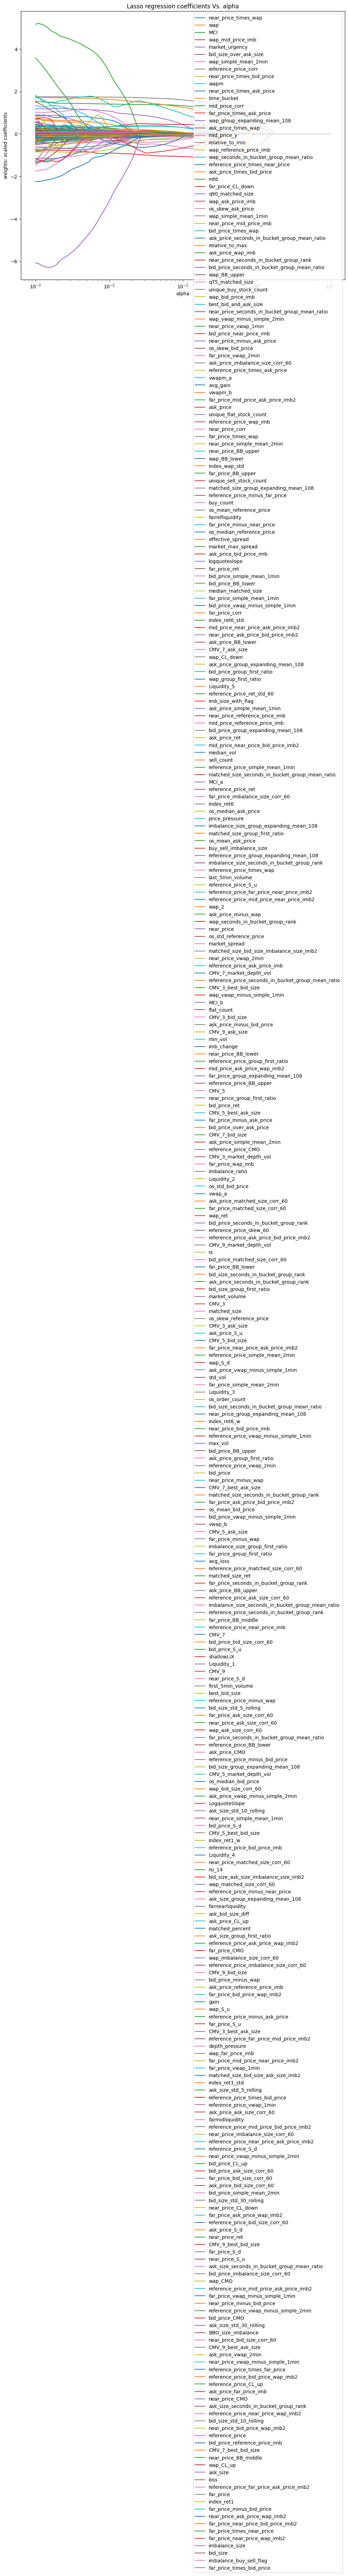

In [53]:
alpha_lasso = 10**np.linspace(-3,1,100)
lasso = Lasso()
coefs_lasso = []

for i in alpha_lasso:
    lasso.set_params(alpha = i)
    lasso.fit(X_train_selected, y_train)
    coefs_lasso.append(lasso.coef_)
    
plt.figure(figsize=(12,10))
ax = plt.gca()
ax.plot(alpha_lasso, coefs_lasso)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights: scaled coefficients')
plt.title('Lasso regression coefficients Vs. alpha')
plt.legend(selected_features)
plt.show()

In [55]:
# fea = X_train.columns
a = pd.DataFrame()
a['feature'] = selected_features
coef = pd.Series(model_lasso.coef_,index=X_train_selected.columns)
a['importance'] = coef.values

a = a.sort_values('importance',ascending = False)
plt.figure(figsize=(12,8))
plt.barh(a['feature'],a['importance'])
plt.title('the importance features')
plt.show()

NameError: name 'model_lasso' is not defined

In [58]:
from sklearn.linear_model import LassoCV
# 使用交叉验证选择最佳 alpha
lasso_cv = LassoCV(alphas=alpha_lasso, cv=5).fit(X_train_selected, y_train)
best_alpha = lasso_cv.alpha_

# 使用最佳 alpha 训练 Lasso 模型
lasso = Lasso(alpha=best_alpha)
lasso.fit(X_train_selected, y_train)
important_features = X_train_selected.columns[lasso.coef_ != 0]
# 获取非零系数及其对应的特征
non_zero_coefs = lasso.coef_[lasso.coef_ != 0]
important_features = X_train_selected.columns[lasso.coef_ != 0]

# 创建 DataFrame 并按系数绝对值排序
feature_importance = pd.DataFrame({
    'Feature': important_features,
    'Coefficient': non_zero_coefs
})
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# 输出重要特征
for feature, coef in zip(feature_importance['Feature'], feature_importance['Coefficient']):
    print(f"Feature: {feature}, Coefficient: {coef}")


Feature: near_price, Coefficient: -6.070631514251982
Feature: near_price_bid_price_imb, Coefficient: 5.1753293456847524
Feature: os_mean_ask_price, Coefficient: 3.5796024058021856
Feature: os_median_bid_price, Coefficient: -2.2487666441000065
Feature: wap_seconds_in_bucket_group_mean_ratio, Coefficient: 1.824052691232649
Feature: os_skew_ask_price, Coefficient: -1.7544365046222137
Feature: relative_to_min, Coefficient: 1.7517200988325838
Feature: os_std_bid_price, Coefficient: 1.7298438583906925
Feature: relative_to_max, Coefficient: 1.7253007674188336
Feature: mid_price_corr, Coefficient: 1.5477832015295079
Feature: os_skew_bid_price, Coefficient: 1.5122306158075525
Feature: reference_price_times_wap, Coefficient: -1.4905629328427692
Feature: os_std_reference_price, Coefficient: -1.3785697239299959
Feature: near_price_minus_wap, Coefficient: 1.3533048132701346
Feature: vwapm_a, Coefficient: -1.3156985427217252
Feature: os_mean_reference_price, Coefficient: -1.2895687545949315
Feature:

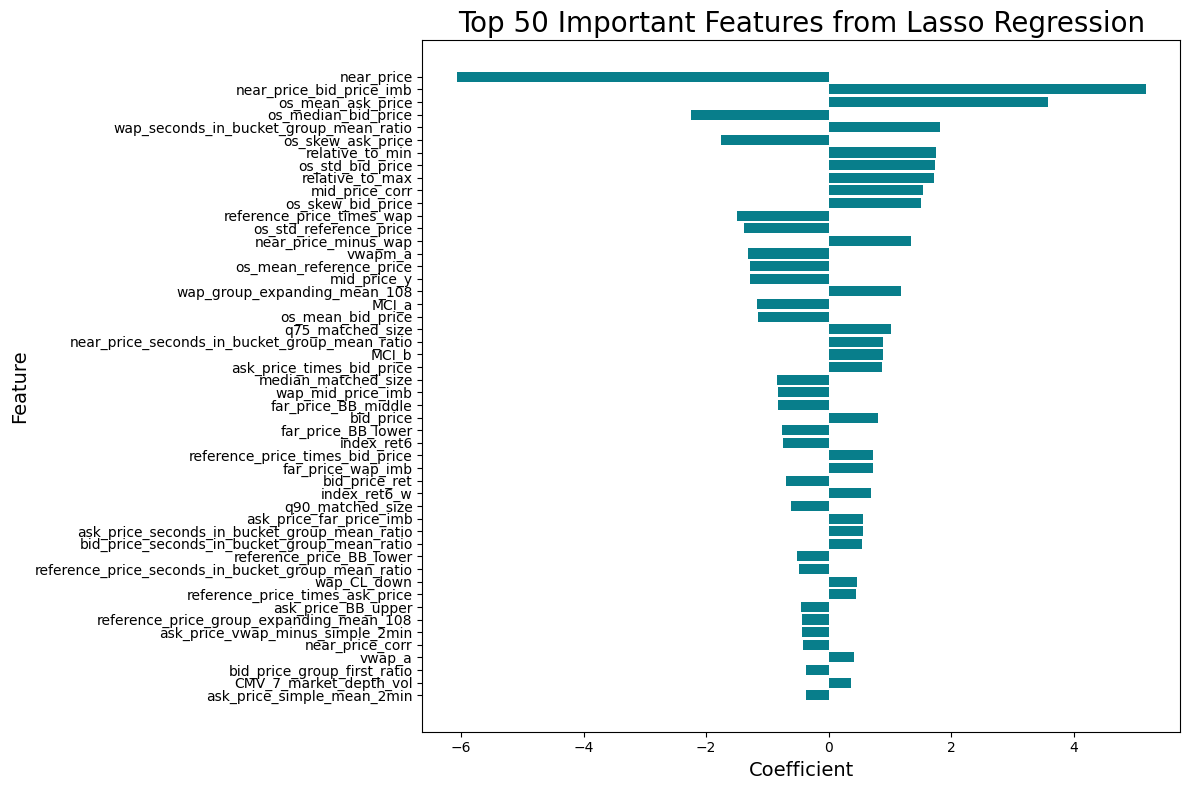

In [61]:
from sklearn.linear_model import LassoCV
import pandas as pd
import matplotlib.pyplot as plt

# 使用交叉验证选择最佳 alpha
lasso_cv = LassoCV(alphas=alpha_lasso, cv=5).fit(X_train_selected, y_train)
best_alpha = lasso_cv.alpha_

# 使用最佳 alpha 训练 Lasso 模型
lasso = Lasso(alpha=best_alpha)
lasso.fit(X_train_selected, y_train)

# 获取非零系数及其对应的特征
non_zero_coefs = lasso.coef_[lasso.coef_ != 0]
important_features = X_train_selected.columns[lasso.coef_ != 0]

# 创建 DataFrame 并按系数绝对值排序
feature_importance = pd.DataFrame({
    'Feature': important_features,
    'Coefficient': non_zero_coefs
})
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# 选择前 50 个重要特征
top_50_features = feature_importance.head(50)

# 设置图形大小
plt.figure(figsize=(12, 8))

# 绘制柱状图
plt.barh(top_50_features['Feature'], top_50_features['Coefficient'], color='#087E8B')

# 设置标题和标签
plt.title('Top 50 Important Features from Lasso Regression', size=20)
plt.xlabel('Coefficient', size=14)
plt.ylabel('Feature', size=14)

# 反转 y 轴，使最重要的特征在顶部
plt.gca().invert_yaxis()

# 显示图形
plt.tight_layout()
plt.show()